In [127]:
import pandas as pd
import numpy as np
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob

In [170]:
models = ['GBT', 'LocalMLP']
experiments = ['best_settings_env', 'best_settings_env']
results = dict()
base_dir = '/home/fiona/birdMigration/results/abm/testing'
for i, m in enumerate(models):
    model_dir = f'{base_dir}/{m}/{experiments[i]}'
    print(model_dir)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results[m] = pd.read_csv(files[0])

/home/fiona/birdMigration/results/abm/testing/GBT/best_settings_env
/home/fiona/birdMigration/results/abm/testing/LocalMLP/best_settings_env


IndexError: list index out of range

In [150]:
models = ['GBT', 'LocalMLP', 'LocalLSTM']
results = dict()
base_dir = '/home/fiona/birdMigration/results/radar/testing'
for m in models:
    model_dir = f'{base_dir}/{m}/best_settings_env'
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results[m] = pd.read_csv(files[0])
#results_GBT = pd.read_csv(osp.join(GBT_dir, 'results.csv'))

#localMLP_dir = '/home/fiona/birdMigration/results/radar/testing/LocalMLP/best_settings/{"n_hidden": 64, "n_layers": 1, "dropout_p": 0.0, "lr": 0.01, "lr_decay": 50}'
#results_MLP = pd.read_csv(osp.join(localMLP_dir, 'results.csv'))

In [155]:
results['GBT'].loc[0, 'gt']

67435.984

In [50]:
results_GBT.columns

Index(['Unnamed: 0', 'gt', 'prediction', 'night', 'radar', 'seqID', 'tidx',
       'datetime', 'trial', 'horizon'],
      dtype='object')

[None, None]

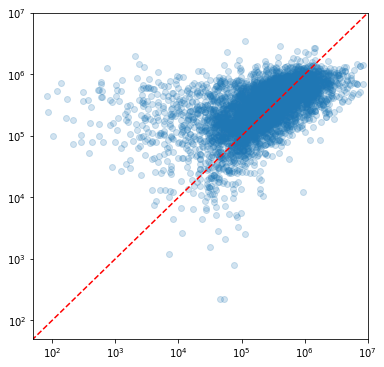

In [46]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(results_GBT['gt'].replace(0, np.nan).values, results_GBT['prediction'].replace(0, np.nan).values, alpha=0.2)
ax.plot([0,1e7], [0, 1e7], ls='--', c='red')
ax.set_xlim(50, 1e7)
ax.set_ylim(50, 1e7)
ax.set(yscale='symlog', xscale='symlog')

[None, None]

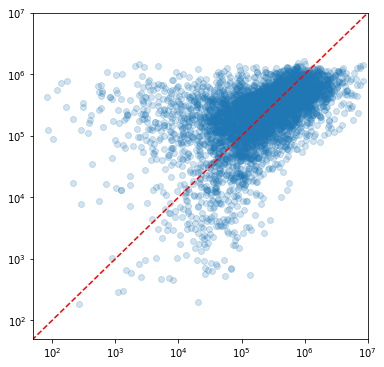

In [101]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(results_MLP['gt'].replace(0, np.nan).values, results_MLP['prediction'].replace(0, np.nan).values, alpha=0.2)
ax.plot([0,1e7], [0, 1e7], ls='--', c='red')
ax.set_xlim(50, 1e7)
ax.set_ylim(50, 1e7)
ax.set(yscale='symlog', xscale='symlog')

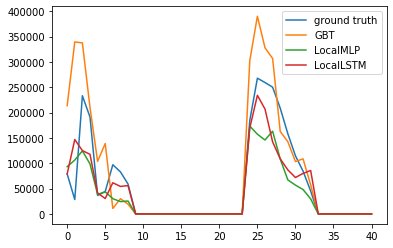

In [164]:
sid = 9
s1 = results['GBT'].query(f'seqID == {sid} & radar == "dehnr" & trial == 0')
s1_mlp = results['LocalMLP'].query(f'seqID == {sid} & radar == "dehnr" & trial == 0')
s1_lstm = results['LocalLSTM'].query(f'seqID == {sid} & radar == "dehnr" & trial == 0')
plt.plot(range(len(s1_lstm)), s1_lstm['gt'], label='ground truth')
plt.plot(range(len(s1)), s1['prediction'] * s1['night'], label='GBT')
plt.plot(range(len(s1_mlp)), s1_mlp['prediction'], label='LocalMLP')
plt.plot(range(len(s1_lstm)), s1_lstm['prediction'], label='LocalLSTM')
plt.legend()

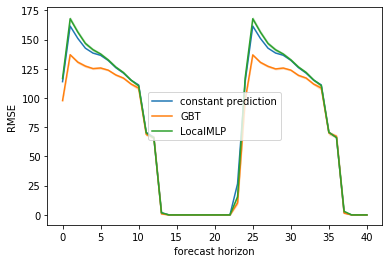

In [169]:
fig, ax = plt.subplots()

for idx, m in enumerate(models):
    if idx == 0:
        constant_prediction = results[m].groupby('radar')['gt'].aggregate(np.mean)
        results[m]['constant_error'] = results[m].apply(lambda row: (row['gt'] - constant_prediction.loc[row.radar] * row.night)**2, axis=1)
        mse_const = results[m].groupby(['horizon', 'trial']).constant_error.mean().apply(np.sqrt)
        mean_mse_c = mse_const.groupby('horizon').aggregate(np.mean)
        ax.plot(mean_mse_c, label='constant prediction')
    
    results[m]['error'] = results[m].apply(lambda row: (row['gt'] - row['prediction'] * row.night)**2, axis=1)
    mse = results[m].groupby(['horizon', 'trial']).error.mean().apply(np.sqrt)
    mean_mse = mse.groupby('horizon').aggregate(np.mean)
    std_mse = mse.groupby('horizon').aggregate(np.std)
    
    l = ax.plot(mean_mse, label=m)
    ax.fill_between(mean_mse.index, mean_mse+std_mse, mean_mse-std_mse, alpha=0.2, color=l[0].get_color())
    
plt.legend()
ax.set(xlabel='forecast horizon', ylabel='RMSE');

In [103]:

results_GBT['error'] = results_GBT.apply(lambda row: (row['gt'] - row['prediction'] * row.night)**2, axis=1)
constant_prediction = results_GBT.groupby('radar')['gt'].aggregate(np.mean)
results_GBT['constant_error'] = results_GBT.apply(lambda row: (row['gt'] - constant_prediction.loc[row.radar] * row.night)**2, axis=1)
mse = results_GBT.groupby(['horizon', 'trial']).error.mean().apply(np.sqrt)
mse_const = results_GBT.groupby(['horizon', 'trial']).constant_error.mean().apply(np.sqrt)
mean_mse = mse.groupby('horizon').aggregate(np.mean)
std_mse = mse.groupby('horizon').aggregate(np.std)

mean_mse_c = mse_const.groupby('horizon').aggregate(np.mean)
std_mse_c = mse_const.groupby('horizon').aggregate(np.std)

results_MLP['error'] = results_MLP.apply(lambda row: (row['gt'] - row['prediction'] * row.night)**2, axis=1)
mse = results_MLP.groupby(['horizon', 'trial']).error.mean().apply(np.sqrt)
mean_mse_mlp = mse.groupby('horizon').aggregate(np.mean)
std_mse_mlp = mse.groupby('horizon').aggregate(np.std)

KeyError: 'horizon'

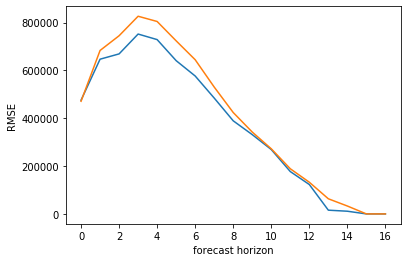

In [99]:

l = ax.plot(mean_mse)
ax.fill_between(mean_mse.index, mean_mse+std_mse, mean_mse-std_mse, alpha=0.2, color=l[0].get_color())
ax.plot(mean_mse_c)
ax.set(xlabel='forecast horizon', ylabel='RMSE');

In [108]:
import xarray as xr
import itertools as it

In [120]:
env = xr.open_dataset('/home/fiona/birdMigration/data/raw/env/fall/2016/pressure_level_850.nc')

In [121]:
env

<xarray.Dataset>
Dimensions:    (latitude: 35, longitude: 61, time: 2928)
Coordinates:
  * longitude  (longitude) float32 0.916 1.1660167 ... 15.666984 15.917
  * latitude   (latitude) float32 55.274 55.024 54.774 ... 47.274 47.024 46.774
  * time       (time) datetime64[ns] 2016-08-01 ... 2016-11-30T23:00:00
Data variables:
    cc         (time, latitude, longitude) float32 ...
    q          (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-19 12:12:33 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [111]:
test_df = pd.DataFrame(dict(night=[0,0,1,1,1,0,0,0,1,1,1,1,0,0]))
check_all = test_df.night.values
groups = [list(g) for k, g in it.groupby(enumerate(check_all), key=lambda x: x[-1])]
nights = [[item[0] for item in g] for g in groups if g[0][1]]

In [125]:
l = [1,2,3,4]
l.remove(1)
l

[2, 3, 4]

In [112]:
nights

[[2, 3, 4], [8, 9, 10, 11]]

In [118]:
test_df['nightID'] = 0
for nidx, night in enumerate(nights):
    test_df.loc[night, 'nightID'] = nidx + 1

In [119]:
test_df

,night,nightID
0,0,0
1,0,0
2,1,1
3,1,1
4,1,1
5,0,0
6,0,0
7,0,0
8,1,2
9,1,2
